In [1]:
# Here is the imports
import os

os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'
FLAGS = [] # tensorboard, mixed_precision
from tensorflow import keras
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
#physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], True)
import albumentations as A
if "mixed_precision" in FLAGS:
    print(f"PreTrain: Using Mixed Policy float16")
    keras.mixed_precision.set_global_policy('mixed_float16')
# keras.mixed_precision.set_global_policy('mixed_float16') normally this would provide extra speed for the model
# but in the case of 1660ti gpus they seem like they have tensor cores even they don't thus it slows down the model use this on higher powered models
from matplotlib import pyplot as plt
AUTOTUNE = tf.data.AUTOTUNE
from tensorflow.keras.models import load_model
from tqdm import tqdm
import cv2
import pandas as pd

In [2]:
# Dataset Constants
test_dir = './data/test/'
save_dir = './results/'
IMG_EXT = 'png'
BATCH_SIZE = 1
LR = 0.0001

MODEL_1_LOAD_TYPE = 'model' # model or weights
MODEL_2_LOAD_TYPE = 'model' # model or weights
MODEL_1_WEIGHT_PATH = "./models/22_09-20_13-eff_last/best.h5"
MODEL_2_WEIGHT_PATH = "./models/22_09-20_13-eff_last/final.h5"

In [3]:
# helper function for data visualization
def visualize(**images):
    """Plot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        # if whole binary image is true plt shows it as whole image is false so for bypassing this issue we assing one pixels value to 0
        image[1,1] = 0 
        plt.imshow(image)
    plt.show()

def visualize_dataset(img, mask, classes):
    kwarg = {'image': img}
    for i in range(len(classes)):
        kwarg.update({classes[i] : mask[..., i].squeeze()})
    visualize(**kwarg)

# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

In [4]:
model1 = load_model(MODEL_1_WEIGHT_PATH)
model2 = load_model(MODEL_2_WEIGHT_PATH)

2021-09-22 22:07:05.539269: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-22 22:07:05.564990: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-22 22:07:05.565413: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-22 22:07:05.566037: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
202

In [5]:
predict_filenames = tf.io.gfile.glob(f"{test_dir}*.{IMG_EXT}")
predict_filenames = predict_filenames[:]
predict_filenames = sorted(predict_filenames)
ids_1 = []
labels_1 = []
inme_yok_1 = 0
inme_var_1 = 0

for i in tqdm(predict_filenames):
    img = cv2.imread(i)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    img = np.expand_dims(img, axis=0)
    prediction = model1.predict(img)
    prediction = prediction[0, 0]
    if prediction < 0.5:
            labels_1.append(1)
    else:
        labels_1.append(0)
    ids_1.append(i.replace(test_dir, '').split('.')[0])

for i in labels_1:
    if i == 1:
        inme_var_1 += 1
    else:
        inme_yok_1 += 1
print(f"Model 1 : İnme yok sayısı {inme_yok_1},  inme var sayısı {inme_var_1}")

  0%|          | 0/128 [00:00<?, ?it/s]2021-09-22 22:07:13.673032: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-09-22 22:07:16.031431: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8204
100%|██████████| 128/128 [00:12<00:00, 10.00it/s]

Model 1 : İnme yok sayısı 75,  inme var sayısı 53


In [6]:
ids_2 = []
labels_2 = []
inme_yok_2 = 0
inme_var_2 = 0

for i in tqdm(predict_filenames):
    img = cv2.imread(i)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    img = np.expand_dims(img, axis=0)
    prediction = model2.predict(img)
    prediction = prediction[0, 0]
    if prediction < 0.5:
            labels_2.append(1)
    else:
        labels_2.append(0)
    ids_2.append(i.replace(test_dir, '').split('.')[0])

for i in labels_2:
    if i == 1:
        inme_var_2 += 1
    else:
        inme_yok_2 += 1
print(f"Model 2 : İnme yok sayısı {inme_yok_2},  inme var sayısı {inme_var_2}")

100%|██████████| 128/128 [00:10<00:00, 12.10it/s]

Model 2 : İnme yok sayısı 78,  inme var sayısı 50


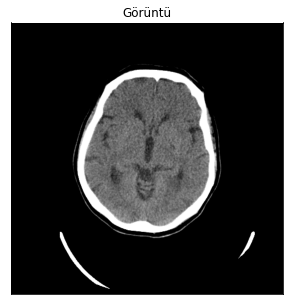

Model 1: 1 | Model 2: 0


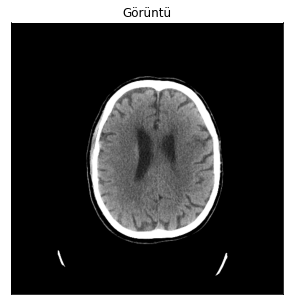

Model 1: 1 | Model 2: 0


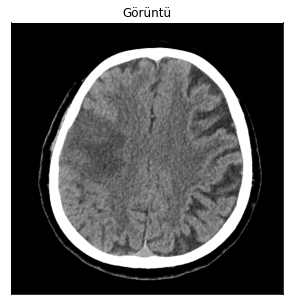

Model 1: 0 | Model 2: 1


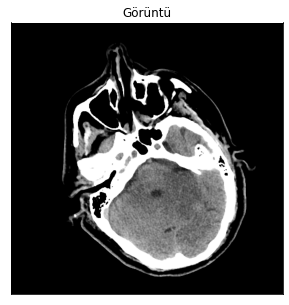

Model 1: 0 | Model 2: 1


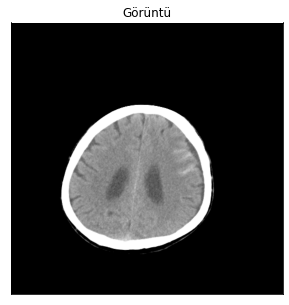

Model 1: 1 | Model 2: 0


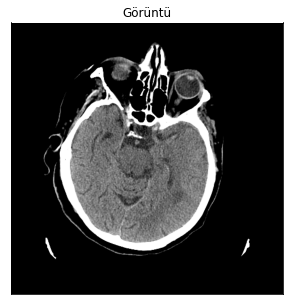

Model 1: 1 | Model 2: 0


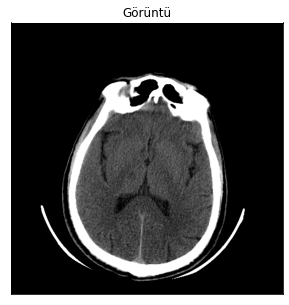

Model 1: 1 | Model 2: 0


In [7]:
assert len(labels_1) == len(labels_2)
for i in range(len(labels_1)):
    if labels_1[i] != labels_2[i]:
        img = cv2.imread(predict_filenames[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = np.expand_dims(img, axis=0)
        visualize(Görüntü=img.squeeze())
        print(f"Model 1: {labels_1[i]} | Model 2: {labels_2[i]}")